# Autoencoder for Recommendation Systems
---

In [502]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [435]:
ratings = pd.read_csv('../data/recommendation_system/ratings.csv')
movies = pd.read_csv('../data/recommendation_system/movies.csv')

In [436]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [437]:
ratings.shape

(100836, 4)

In [438]:
data = pd.pivot_table(
    data=ratings,
    columns='movieId',
    index='userId',
    values='rating'
)

In [439]:
data.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [440]:
def sparsity_calculation(data):
    data = np.nan_to_num(data)
    return round(1. - np.count_nonzero(data) / data.size, 3) * 100

In [441]:
sparsity_calculation(data)

98.3

In [442]:
scaler = StandardScaler()
scaler.fit(data)

StandardScaler()

In [443]:
data_scaled = pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns).fillna(0)

In [444]:
data_scaled.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.094931,0.0,0.708752,0.0,0.0,0.066307,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.094931,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [463]:
model = tf.keras.Sequential([
    #encoder
    tf.keras.layers.Dense(units=512, activation='relu', name='enc_1', input_dim=data_scaled.shape[1]),
    tf.keras.layers.BatchNormalization(name='batch_1'),
    tf.keras.layers.Dropout(0.5, name='drop_1'),
    tf.keras.layers.Dense(units=256, activation='relu', name='enc_2'),
    tf.keras.layers.BatchNormalization(name='batch_2'),
    tf.keras.layers.Dropout(0.5, name='drop_2'),

    #bottleneck
    tf.keras.layers.Dense(units=128, activation='relu', name='embeddings'),

    #decoder
    tf.keras.layers.Dense(units=256, activation='relu', name='dec_1'),
    tf.keras.layers.BatchNormalization(name='batch_3'),
    tf.keras.layers.Dropout(0.5, name='drop_3'),
    tf.keras.layers.Dense(units=512, activation='relu', name='dec_2'),
    tf.keras.layers.BatchNormalization(name='batch_4'),
    tf.keras.layers.Dropout(0.5, name='drop_4'),
    tf.keras.layers.Dense(units=data_scaled.shape[1], activation='relu', name='user_rating_pred')
])

In [464]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_1 (Dense)               (None, 512)               4979200   
                                                                 
 batch_1 (BatchNormalization  (None, 512)              2048      
 )                                                               
                                                                 
 drop_1 (Dropout)            (None, 512)               0         
                                                                 
 enc_2 (Dense)               (None, 256)               131328    
                                                                 
 batch_2 (BatchNormalization  (None, 256)              1024      
 )                                                               
                                                                 
 drop_2 (Dropout)            (None, 256)              

In [465]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

In [466]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [467]:
history = model.fit(
    data_scaled,
    data_scaled,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[callback]
)

Epoch 1/50
9/9 [==============================] - 2s 81ms/step - loss: 0.1128 - val_loss: 0.0246
Epoch 2/50
9/9 [==============================] - 1s 60ms/step - loss: 0.1078 - val_loss: 0.0247
Epoch 3/50
9/9 [==============================] - 1s 62ms/step - loss: 0.1016 - val_loss: 0.0249
Epoch 4/50
9/9 [==============================] - 1s 66ms/step - loss: 0.0971 - val_loss: 0.0252
Epoch 5/50
9/9 [==============================] - 1s 61ms/step - loss: 0.0926 - val_loss: 0.0256
Epoch 6/50
9/9 [==============================] - 1s 62ms/step - loss: 0.0887 - val_loss: 0.0262
Epoch 7/50
9/9 [==============================] - 1s 67ms/step - loss: 0.0844 - val_loss: 0.0270
Epoch 8/50
9/9 [==============================] - 1s 67ms/step - loss: 0.0814 - val_loss: 0.0279
Epoch 9/50
9/9 [==============================] - 0s 54ms/step - loss: 0.0773 - val_loss: 0.0289
Epoch 10/50
9/9 [==============================] - 0s 53ms/step - loss: 0.0750 - val_loss: 0.0299
Epoch 11/50
9/9 [============

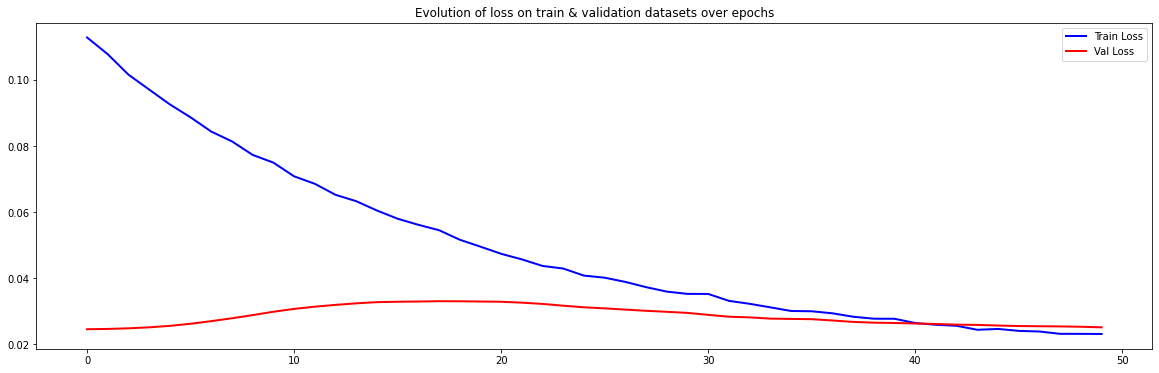

In [468]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']

plt.figure(figsize=(20,6))
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

In [480]:
predictions = model.predict(data_scaled)

In [481]:
predictions = pd.DataFrame(scaler.inverse_transform(predictions), columns=data_scaled.columns, index=data_scaled.index)

In [482]:
predictions.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,3.977975,3.489798,3.310902,2.379281,3.104244,3.980164,3.228327,2.908198,3.151192,3.580476,...,3.5,3.054390,4.016104,4.036620,3.5,4.010660,3.543392,3.528217,3.531490,4.037915
2,3.969248,3.486055,3.286455,2.391527,3.125786,4.001696,3.205983,2.903627,3.142722,3.557061,...,3.5,3.055744,4.003867,4.023722,3.5,4.007668,3.535733,3.516908,3.528641,4.030457
3,3.973889,3.480745,3.294134,2.391290,3.122657,3.993728,3.208127,2.903424,3.142411,3.567183,...,3.5,3.053190,4.002650,4.026421,3.5,4.009479,3.539331,3.518969,3.528248,4.033315
4,3.993111,3.472938,3.305927,2.387459,3.135081,4.000187,3.206925,2.908830,3.142813,3.572953,...,3.5,3.043416,4.000000,4.015167,3.5,4.007619,3.548050,3.517878,3.524243,4.036775
5,3.969837,3.477237,3.286468,2.397398,3.129447,4.001042,3.202674,2.904456,3.135589,3.554588,...,3.5,3.056362,4.004320,4.022439,3.5,4.007188,3.535753,3.515093,3.529944,4.034026


In [497]:
def recommend_for_user(user_item_matrix, content_data, user_id, top_n=10):

    rating = user_item_matrix.loc[user_id].to_frame('rating')
    recommendations = (
        rating
            .join(content_data.set_index('movieId'))
            .sort_values(by='rating', ascending=False)

    )
    if top_n is not None:
        recommendations = recommendations.iloc[:top_n]
        return recommendations[recommendations['rating'] > 0]
    else:
        return recommendations[recommendations['rating'] > 0]

In [498]:
user_id = 4

preds = recommend_for_user(user_item_matrix=predictions, content_data=movies, user_id=user_id, top_n=None)

In [499]:
real = recommend_for_user(user_item_matrix=data, content_data=movies, user_id=user_id, top_n=None)

In [510]:
mean_squared_error(real['rating'], preds[preds.index.isin(real.index)]['rating']) ** 0.5

0.9728232929471157